In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch

In [2]:
import elfragmentador
elfragmentador.__version__

'0.50.0b2'

In [3]:
from elfragmentador.model import PepTransformerModel
from elfragmentador import constants

try:
    model = PepTransformerModel.load_from_checkpoint('/home/jspaezp/Downloads/0.50.0a5_onecycle_5e_C_val_l=0.038469_epoch=004.ckpt')
except RuntimeError as e:
    print(e)
    saved_ckpt = torch.load('/home/jspaezp/Downloads/0.50.0a5_onecycle_5e_C_val_l=0.038469_epoch=004.ckpt', map_location="cpu")
    state_dict = saved_ckpt['state_dict']
    state_dict.pop("decoder.peak_decoder.layers.1.weight")
    state_dict.pop("decoder.peak_decoder.layers.1.bias")
    model = PepTransformerModel(**saved_ckpt['hyper_parameters'])
    model.load_state_dict(state_dict=state_dict, strict=False)
    print(model)

model.eval()

ERROR:root:'RTFFN' not found, please provide to the trainable sections one of {_model_sections}
ERROR:root:'RTFFN' not found, please provide to the trainable sections one of {_model_sections}


Error(s) in loading state_dict for PepTransformerModel:
	Missing key(s) in state_dict: "irt_decoder.multihead_attn.in_proj_weight", "irt_decoder.multihead_attn.in_proj_bias", "irt_decoder.multihead_attn.out_proj.weight", "irt_decoder.multihead_attn.out_proj.bias", "irt_decoder.targets.weight", "irt_decoder.out_mlp.layers.0.weight", "irt_decoder.out_mlp.layers.0.bias", "irt_decoder.out_mlp.layers.1.weight", "irt_decoder.out_mlp.layers.1.bias", "irt_decoder.out_mlp.layers.2.weight", "irt_decoder.out_mlp.layers.2.bias". 
	Unexpected key(s) in state_dict: "rt_decoder.self_attn.in_proj_weight", "rt_decoder.self_attn.in_proj_bias", "rt_decoder.self_attn.out_proj.weight", "rt_decoder.self_attn.out_proj.bias", "rt_decoder.multihead_attn.in_proj_weight", "rt_decoder.multihead_attn.in_proj_bias", "rt_decoder.multihead_attn.out_proj.weight", "rt_decoder.multihead_attn.out_proj.bias", "rt_decoder.linear1.weight", "rt_decoder.linear1.bias", "rt_decoder.linear2.weight", "rt_decoder.linear2.bias", "r

PepTransformerModel(
  (encoder): _PeptideTransformerEncoder(
    (aa_encoder): AASequenceEmbedding(
      (fw_position_embed): SeqPositionalEmbed()
      (rev_position_embed): SeqPositionalEmbed()
      (aa_encoder): Embedding(24, 108, padding_idx=0)
      (mod_encoder): Embedding(15, 108, padding_idx=0)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
          )
          (linear1): Linear(in_features=120, out_features=354, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=354, out_features=120, bias=True)
          (norm1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2)

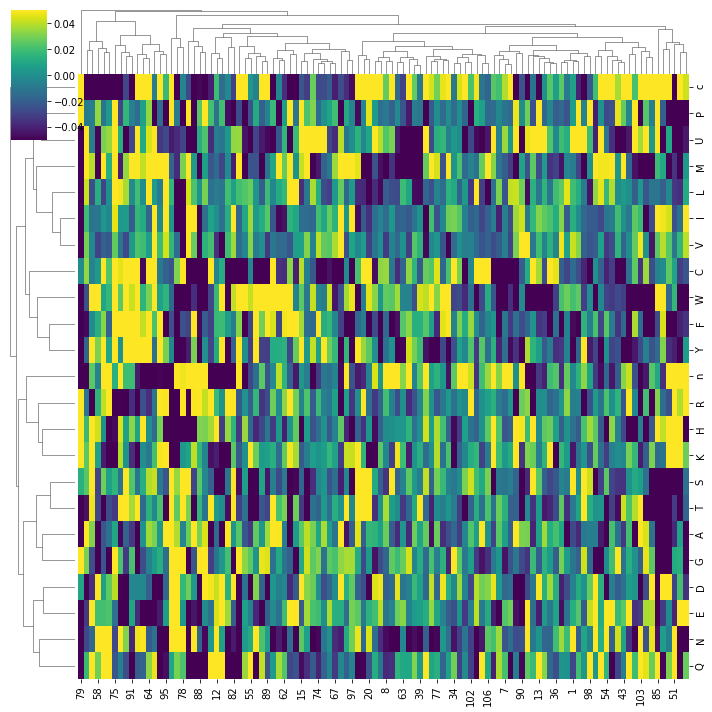

In [4]:
AAS = list(constants.ALPHABET.keys())
AA_NAMES = ["#"] + AAS

aa_weight_df = pd.DataFrame(model.encoder.aa_encoder.aa_encoder.weight.data.numpy(), index = AA_NAMES)
aa_weights = aa_weight_df.loc[[x for x in AAS]]
p = sns.clustermap(
    aa_weights, z_score = None, col_cluster=True,
    cmap = 'viridis',
    figsize = (10,10), dendrogram_ratio = (0.1, 0.1),
    method = "ward", vmin=-0.05, vmax=0.05)

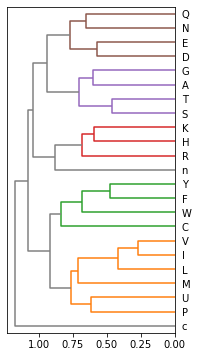

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Calculate the distance between each sample
Z = linkage(aa_weights, 'ward')
 
# Make the dendro
plt.subplots(figsize=(3, 6))
dendrogram(Z, labels=aa_weights.index, orientation="left", color_threshold=0.85, above_threshold_color='grey', distance_sort='ascending')
plt.show()

(23, 2)


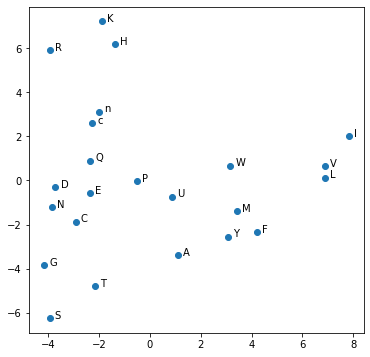

In [8]:

x = StandardScaler().fit_transform(aa_weights.values.T).T

pca = PCA(n_components = 2)
pca_weights = pca.fit_transform(x)
print(pca_weights.shape)

plt.subplots(figsize=(6, 6))
plt.scatter(pca_weights[...,0], pca_weights[...,1])
for i in range(0, len(aa_weights)):
    plt.text(pca_weights[i,0] + 0.2, pca_weights[i,1], aa_weights.index[i])

plt.show()


In [31]:
from elfragmentador import visualization

peptides = [
    ["FELNDDYPSLPSMGWAS", 2, 30],
    ["FELNDDYPSLPS[PHOSPHO]MGWAS", 2, 30],
    ["FELNDDYPSLPSM[OXIDATION]GWAS", 2, 30],
]

with visualization.SelfAttentionExplorer(model) as sae:
    for pep in peptides:
        _ = model.predict_from_seq(*pep)

sae

>>> SelfAttentionExplorer <<<<

>> AA sequences (aa_seqs):
{Embedding(24, 108, padding_idx=0): ['nFELNDDYPSLPSMGWASc', 'nFELNDDYPSLPSMGWASc', 'nFELNDDYPSLPSMGWASc']}
>> Charges (charges):
{ConcatenationEncoder(
  (dropout): Dropout(p=0.1, inplace=False)
): [2, 2, 2]}
>> Encoder vizs (encoder_viz) torch.Size([3, 32, 32]):
{MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
): tensor([[[0.0604, 0.0808, 0.0541,  ..., 0.0000, 0.0000, 0.0000],
         [0.1572, 0.1085, 0.1041,  ..., 0.0000, 0.0000, 0.0000],
         [0.1154, 0.1026, 0.0809,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0535, 0.0370, 0.0305,  ..., 0.0000, 0.0000, 0.0000],
         [0.0535, 0.0370, 0.0305,  ..., 0.0000, 0.0000, 0.0000],
         [0.0535, 0.0370, 0.0305,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0482, 0.0703, 0.0492,  ..., 0.0000, 0.0000, 0.0000],
         [0.1532, 0.1066, 0.1021,  ..., 0.0000, 0.0000, 0.0000],
         [0.1143, 0.1020,

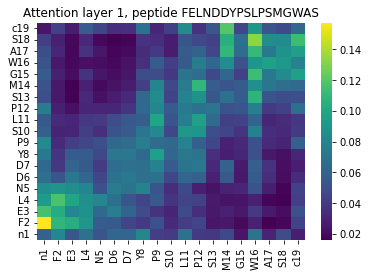

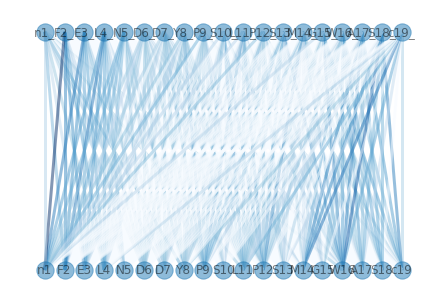

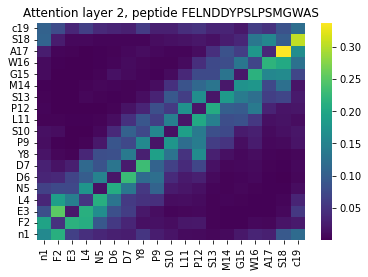

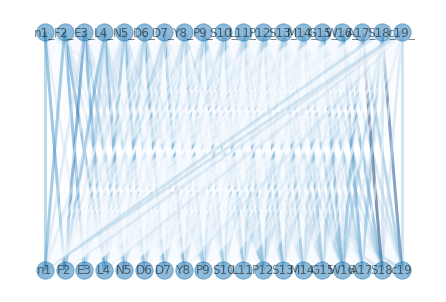

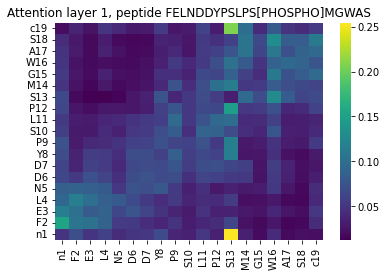

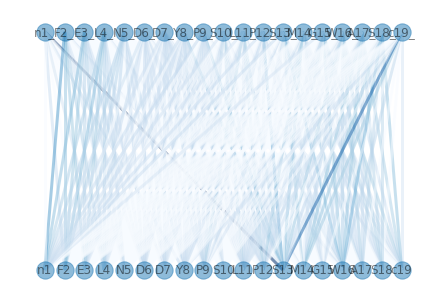

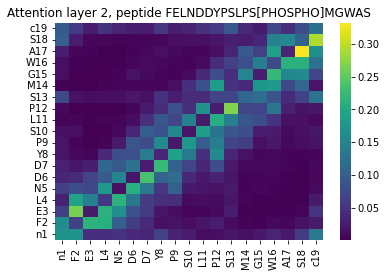

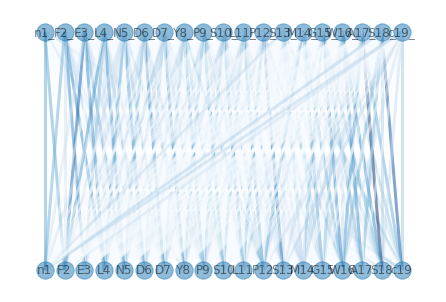

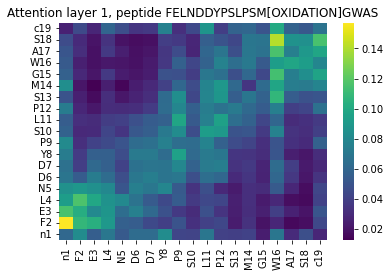

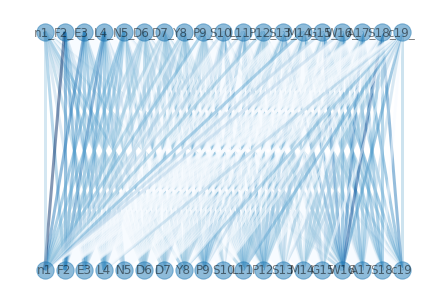

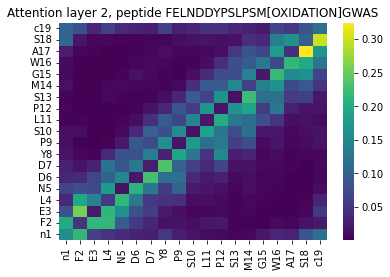

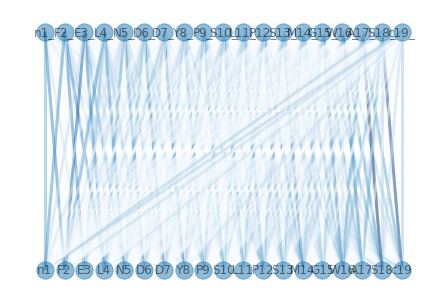

In [32]:
for i, pep in enumerate(peptides):
    for lay in [0, 1]:
        attn_vals = sae.get_encoder_attn(layer=lay, index=i)
        sns.heatmap(
            attn_vals,
            cmap = 'viridis')
        plt.title(f"Attention layer {lay + 1}, peptide {pep[0]}")
        plt.show()


        visualization.plot_bipartite_seq(
            visualization.make_bipartite(attn_vals)
        )